# <img src="./assets/course-icon.png" style="height:50px;display:inline"> Deep Learning
---

create by Arwin Yu

## Tutorial 08 - Graph Neural Network(GNN)
---
<center><img src="./assets/ddpm1.png" style="height:400px"></center>

### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* 图神经网络的基本原理
* MPNN的实现与使用 
    * GNN的层结构与连接性
    * GNN的模型训练
    * 图数据的数据增强 
* GNN的变体
    * GCN
    * GraphSAGE
    * GAT
* Demo项目：Cora

## <img src="https://img.icons8.com/cute-clipart/64/000000/alarm.png" style="height:50px;display:inline"> 图神经网络的基本原理
---
GNN工作原理基于邻域聚合（或消息传递）策略，其中每个节点通过聚合和转换其邻居节点的信息来更新自己的表示。

这个过程通常包括以下几个步骤：
1. 消息聚合：对于给定的节点，从其邻居收集信息。这涉及到对邻居节点的特征向量进行聚合操作，如求和、平均或最大化。
2. 更新：结合当前节点的特征和聚合来自邻居的信息来更新节点的表示。这个更新过程通常通过一个神经网络（如全连接层）实现。
3. 重复：上述过程可以重复多次，每一次迭代允许信息传递更远的距离，从而捕获更宽范围内的图结构特征。
4. 输出：最终，对节点的嵌入可以通过各种方式被利用，如直接用于节点级任务，或者通过汇总所有节点的表示来用于图级任务。

GNN在多个领域都有广泛的应用，如社交网络分析、推荐系统、蛋白质结构预测、化学分子性质预测、知识图谱推理以及交通网络优化等。下面我们将进行详细的介绍。

---

## <img src="https://img.icons8.com/?size=100&id=UbGxE3jdp6dX&format=png&color=000000" style="height:50px;display:inline"> MPNN的实现与使用
---

* 我们将描述使用图神经网络（GNN）来解决图预测任务。
* GNN是对图的所有属性（节点、边、全局信息）的一种可优化的转换，它保留了图的对称性（permutation invariances）。
* 笔者将使用Gilmer等人提出的“消息传递神经网络（message passing neural network）”框架来构建GNN，这是GNN中最简单最基础的框架。
* 消息传递神经网络采用**图进图出**的架构，意味着消息传递神经网络接受一个图作为输入，将信息加载到其节点、边和全局上下文中，并逐步转化这些节点向量、边向量和全局信息，**让其向量表示更具意义，而不改变输入图的连接性**。
* 最后输出一个向量表示更合理的图结构。


<center><img src="./assets/gnn1.png" style="height:400px"></center>

* 当GNN模型训练完毕以后，可以使用训练后的特征向量进行相关的分类或预测任务
* 以二元分类的问题进行举例，因为这个情况可以很容易地扩展到多类或回归情况。
* 如果任务是对节点进行二元预测，对于每个节点的向量，应用一个线性分类器即可。
如下图：

<center><img src="./assets/gnn2.png" style="height:400px"></center>

* 然而，实际上没有那么简单。
* 例如关系的分类信息可能存储在边向量中，而不是存储在节点向量中。
* 这时，仅仅依靠节点向量进行分类预测就显得有些单薄，我们需要一种方法来收集边上的信息，可以通过池化来做到这一点。
* 池化分两步进行：
    * 首先对于每个要汇聚的属性，收集它们的向量表示，并将它们串联成一个矩阵。
    * 然后，对这个矩阵进行某种池化操作，通常是通过一个求和的操作。


<center><img src="./assets/gnn3.png" style="height:300px"></center>

通过求和操作，可以把两个边向量的信息和当前节点向量的信息汇聚在一起映射成一个新的汇聚向量。

**同样的思想也可以运用在边向量和全局向量上**。

现在，我们可以建立一个简单的GNN模型，如下图所示，并通过汇聚图中不同属性的信息进行二分类预测。其中，汇集操作将作为构建更复杂的GNN模型的基石。


<center><img src="./assets/gnn4.png" style="height:300px"></center>

请注意，在这个最简单的GNN表述中，**在GNN层内根本没有使用图的连接性（邻接矩阵/列表）**。每个节点都是独立处理的，每条边也是如此，还有全局环境。
**只在汇集信息进行预测时使用连接性。**

### 图神经网络的层结构与连接性

那么应该如何融入邻接矩阵的信息呢？可能很直接地可以想到，将邻接矩阵和特征合并在一起应用在深度神经网络上，如下图所示，直接将一个节点的邻接矩阵+特征合起来作为一个观测。

<center><img src="./assets/gnn5.png" style="height:300px"></center>

但是，这种方法的问题在于：

（1）需要的较大的参数复杂度；

（2）不适用于不同大小的图；

（3）对节点顺序敏感。

解决方法是将卷积神经网络的思想泛化到图神经网络上。具体来说，就是局部相关性和层级结构。


<center><img src="./assets/gnn6.png" style="height:600px"></center>

* 图片数据是规则的，因此在定义局部相关性时，可以通过定义一个卷积核来实现，卷积核的尺寸决定着局部的范围大小。

* 图数据的不规则的，因此不能采用卷积核的方式来实现局部相关性。这里采用的是聚合邻居节点的方式，即根据邻接矩阵的信息，在每个GNN层中融合节点邻居的信息。

* 如果实际任务还是需要很多层GNN网络，那么可以在GNN模型中增加skip connections。这个想法来源于CNN算法中的ResNet模型。

另一方面，融合节点邻居信息这一思想，与神经网络的分层结构是非常相似的，如图


<center><img src="./assets/gnn7.png" style="height:400px"></center>

* 从本质上讲，GNN中的消息传递和CNN中的卷积核操作都是处理一个元素的邻居的信息，以便更新该元素的值。
* GNN的层数往往不会太深，这与图数据的性质有关，读者还记得那个地球村有趣的说法吗？
* 接下来的问题是，根据邻接矩阵对节点的信息进行汇聚之后的操作是什么？

<center><img src="./assets/gnn8.png" style="height:300px"></center>

* 值得注意的是，这个MLP是应用在单独的节点、边或全局向量上的，这意味着节点和边之间不能通过这个MLP进行信息的交互，这肯定是不合理的。

* 其实解决办法也很简单，就是在向量输入MLP之前，先进行在节点和边之间进行汇聚操作。

<center><img src="./assets/gnn9.png" style="height:300px"></center>

### 图神经网络模型的训练

GNN的训练流程如下

（1）输入数据；

（2）用GNN训练数据；

（3）得到节点向量；

（4）送入Predictor（本质是一个MLP，将节点向量转换为最终需要的预测向量）；

（5）得到预测向量；

（6）选取损失函数和标签计算损失；

（7）根据损失更新模型参数直到收敛；

（8）选取评估指标测试模型；

（9）使用模型解决实际问题。

如下图所示

<center><img src="./assets/gnn10.png" style="height:400px"></center>

Predictor其实就算一个MLP，用来改变向量维度的，目的是变化成想要的预测向量的形状。这里解释一些不同粒度任务下的Predictor。

如果是**边级别的预测任务**，预测节点之间是否有边。

这时候可以将节点向量 $\boldsymbol{u}$ 和 $\boldsymbol{v}$ 进行拼接, 拼接后的向量在送入 Predictor 进行维度变化即可, 即 $\hat{y}_{u v}=\operatorname{MLP}\left(\operatorname{Concat}\left(h_u^{(L)}, \mathrm{h}_v^{(L)}\right)\right)$ 。

也可以是点积操作（dot product）。因为两个向量的点积结果意味着两个向量的相关程度，是一个常数。当两个向量的点积结果大时，意味着这两个节点之间有很大可能存在边。

如果是**图级别的任务**，可以聚合图中所有节点（global pooling）的节点向量来做预测，其中聚合方式有很多：

* (1) global mean pooling: 
    * $\hat{y}_G=\operatorname{Mean}\left(h_v^{(L)} \in R^d, \forall v \in G\right)$;

* (2) global max pooling: 
    * $\hat{y}_G=\operatorname{Max}\left(h_v^{(L)} \in R^d, \forall v \in G\right)$;

* (3) global sum pooling: 
    * $\hat{y}_G=\operatorname{Sum}\left(h_v^{(L)} \in R^d, \forall v \in G\right)$ 。

这些聚合方式其实有一定的选择技巧，例如：
* 如果想比较不同大小的图，mean方法可能比较好，因为结果不受节点数量的影响；
* 如果关心图的大小等信息，sum方法可能比较好，因为可以体现图的节点数量。
* 如果关心图的某些重要特征，max方法会好一些，因为可以体现图中最重要的节点信息。

这些方法都在小图上表现很好。但是在大图上的global pooling方法可能会面临丢失信息的问题。举例：
* G1的节点嵌入为 { − 1 , − 20 , 0 , 1 , 20 }； 
* G2的节点嵌入为 { − 10 , − 20 , 0 , 10 , 20 } ，
* 显然两个图的节点嵌入差别很大，图结构很不相同。
* 但是经过global sum pooling后：不管是求平均，还是求最大，还是求和。这两个图的表示向量一样了，无法做出区分。

为了解决这一问题, 解决方法是分层聚合节点向量 (hierarchical global pooling)。

具体来说, 可以使用 $\operatorname{ReLU}(\operatorname{Sum}(\cdot))$ 做聚合, 先分别聚合前两个节点和后三个节点的嵌入, 然后再聚合这两个嵌入。举例如下:

* G1 :

    * 第一轮聚合: $\hat{y}_a=\operatorname{ReLU}(\operatorname{Sum}(\{-1,-20\}))=0, \hat{y}_b=\operatorname{ReLU}(\operatorname{Sum}(\{0,1,20\}))=21$

    * 第二轮聚合: $\hat{y}_G=\operatorname{ReLU}\left(\operatorname{Sum}\left(\left\{y_a, y_b\right\}\right)\right)=21$

* G2:
    * 第一轮聚合: $\hat{y}_a=\operatorname{ReLU}(\operatorname{Sum}(\{-10,-20\}))=0, \hat{y}_b=\operatorname{ReLU}(\operatorname{Sum}(\{0,10,20\}))=30$

    * 第二轮聚合: $\hat{y}_G=\operatorname{ReLU}\left(\operatorname{Sum}\left(\left\{y_a, y_b\right\}\right)\right)=30$


这样就可以将G1​和G2​作出区分了。其实，这种分层聚合得到图级别预测结果的方式，某种程度上非常类似于CNN处理图像识别问题的层级结构，如图


<center><img src="./assets/gnn11.png" style="height:400px"></center>

### 图数据的数据增强

图数据的数据增强（Graph Augmentation for GNNs）简称图增强，可以从特征层面或结构层面进行展开。

主要解决的问题是现实生活中很多图数据不规范，不能直接适用GNN进行处理，要进行一定的数据预处理。

**节点特征层面**

现实生活中，图数据往往体量很庞大，很多节点是没有特征的，或者只有一小部分节点存在特征。没有特征的话怎么聚合节点信息呢？

* 这里主要有两种简单的直接给每个节点加上特征的方法：
    * （1）直接给每个节点加上同样的值，也就是给每个节点赋常数特征
    * （2）独热编码：给每个节点赋唯一ID，将ID转换为独热编码向量的形式。


<center><img src="./assets/gnn12.png" style="height:300px"></center>

虽然这种方法看起来好像没什么用，但实际应用是有效的。

举例：假设图9-30中各个节点采样两层的邻居节点：A节点的一阶邻居是BCD，二阶邻居是AC、AEF、A。

所以如果使用加法作为聚合信息的方法的话，而且还有聚合其本身的话，最后的结果就是（1+1+1）+（1+1+1+1+1）+（1+1）+ 1 = 11。这个数值有点像是节点度数，是根据图结构信息聚合得到的。

相比于赋值常量，独热编码方法的表达性更强，在最开始时就能体现不同的节点。但是，一个难以处理的地方是输入one-hot的维度是取决于输入图的节点数量，如果有新节点加入，可能会改变之前所有节点的向量长度。

除了上面两种简单的方法，也可以根据**图的各种属性**来进行节点向量的初始化。

* 例如
    * 节点的度（Node degree）
    * 度中心性 （Degree Centrality）
    * 特征向量中心性（Eigenvector Centrality）
    * 中介中心性（Betweenness Centrality）
    * 接近中心性（Closeness Centrality）等等。

这些属性可以让节点更好的表示图的结构信息。

值得注意的是，一些特定的结构难以被GNN学习，如下图所示，v1的度数都是2，但是所在的图完全不同，这就导致输入基本特征难以学习到这个特性。


<center><img src="./assets/gnn13.png" style="height:260px"></center>

这种问题的解决方法也很简单：具体问题具体对待。

可以通过环计数来区分上面的两个v1，图左侧的环计数为3，图右侧的环计数为4，将3和4这两个常量作为特征分别添加到节点的特征向量中即可。

这个方法可以扩展到其它具体问题中，例如，在蛋白质分子模型中，每个节点代表一个原子，可以把原子的电荷数量、质量、体积等都作为特征向量的元素。

**图结构层面**

图结构层面的数据增强主要是用来解决图结构过于稀疏或过于稠密的问题。

图结构过度稀疏可能导致信息传递效率低，因为边太少了，很有可能出现图中两个节点相距太远，信息交互困难。

反之，图过度稠密则会导致信息传递的计算代价太高，每次计算都需要对好几个节点做运算，因为图稠密意味着邻接节点多。

针对图稀疏问题，可以为两个跳邻居和目标节点之间增加一个虚拟边：

<center><img src="./assets/gnn14.png" style="height:260px"></center>


当然，也可以增加虚拟点：
<center><img src="./assets/gnn15.png" style="height:260px"></center>

不管是增加边，还是增加节点，都可以提升在稀疏图中的信息传递能力。

对于过于**稠密的图数据**，如果聚合所有的邻居节点的话，最后计算的成本可能较高。

为了解决这种情况，可以使用采样方法，即每次只**随机采样个N邻居，然后开始聚合**。

这个想法在图模型Graph Sample and Aggregate Network（GraphSAGE）就有应用。

优点是可以每次抽样不同的邻居，以增加模型鲁棒性，并且可以控制参数，来控制计算量；

缺点也很明显，可能会损失重要信息，因为有的邻居直接不使用。

## <img src="https://img.icons8.com/?size=100&id=yMucvCMFOUlg&format=png&color=000000" style="height:50px;display:inline"> 图卷积网络（GCN）
---
 

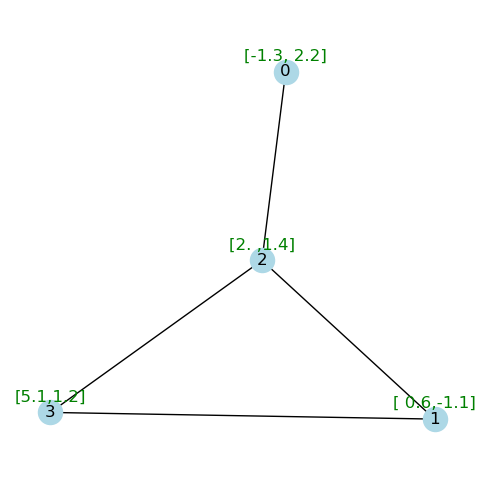

In [2]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import Any, Dict, Tuple, Union, List

warnings.simplefilter(action="ignore", category=FutureWarning)

plt.style.use("default")

G = nx.Graph()
# our example graph consists of 4 nodes with 2-dimensional features
G.add_nodes_from(
    [
        (0, {"x": [-1.3, 2.2]}),
        (1, {"x": [0.6, -1.1]}),
        (2, {"x": [2.0, 1.4]}),
        (3, {"x": [5.1, 1.2]}),
    ]
)
# create the edges
edge_list = [(0, 2), (1, 2), (1, 3), (2, 3)]
G.add_edges_from(edge_list)

pos = nx.spring_layout(G)


def nudge(pos: Dict[int, np.ndarray], x_shift: float, y_shift: float):
    """Nudge position to position attributes"""
    return {n: (x + x_shift, y + y_shift) for n, (x, y) in pos.items()}


def draw_graph_with_attributes(
    G: nx.Graph,
    props: Dict[int, Any] = None,
    pos: Dict[int, np.ndarray] = None,
    figsize: Tuple[int, int] = (6, 6),
    x_nudge: float = 0.0,
    y_nudge: float = 0.07,
    ax: mpl.axes.Axes = None,
    font_color: str = "green",
    edge_color: str = "black",
    node_color: Union[str, List] = "lightblue",
):
    """Draw a graph with node labels and attributes"""
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    if pos is None:
        pos = nx.spring_layout(G)

    nx.draw_networkx(G, pos=pos, with_labels=True, ax=ax, edge_color=edge_color, node_color=node_color)
    pos_nudged = nudge(pos, x_nudge, y_nudge)
    if props is None:
        props = nx.get_node_attributes(G, "x")
        props = {
            node_id: np.array2string(np.array(x), precision=2, separator=",")
            for node_id, x in props.items()
        }
    nx.draw_networkx_labels(
        G, pos=pos_nudged, labels=props, ax=ax, font_color=font_color
    )
    ax.set_ylim(tuple(i * 1.1 for i in ax.get_ylim()))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)


draw_graph_with_attributes(G, pos=pos)

### 邻接矩阵

In [3]:
A = nx.adjacency_matrix(G).toarray()
A

array([[0, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 1, 0, 1],
       [0, 1, 1, 0]])

### 节点特征矩阵


In [4]:
props = nx.get_node_attributes(G, "x")
X = np.array([props[i] for i in range(len(G))])
X

array([[-1.3,  2.2],
       [ 0.6, -1.1],
       [ 2. ,  1.4],
       [ 5.1,  1.2]])

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> 考虑邻接矩阵A，与节点特征X相乘是否有意义？
---

Given:

Adjacency matrix $A$ :
$$
\left[\begin{array}{llll}
0 & 0 & 1 & 0 \\
0 & 0 & 1 & 1 \\
1 & 1 & 0 & 1 \\
0 & 1 & 1 & 0
\end{array}\right]
$$

Feature matrix $H$ :
$$
\left[\begin{array}{cc}
-1.3 & 2.2 \\
0.6 & -1.1 \\
2.0 & 1.4 \\
5.1 & 1.2
\end{array}\right]
$$

We will perform the matrix multiplication $A H$ :

$AH=\left[\begin{array}{ll}0 *(-1.3)+0 * 0.6+1 * 2.0+0 * 5.1 & 0 * 2.2+0 *(-1.1)+1 * 1.4+0 * 1.2 \\ 0 *(-1.3)+0 * 0.6+1 * 2.0+1 * 5.1 & 0 * 2.2+0 *(-1.1)+1 * 1.4+1 * 1.2 \\ 1 *(-1.3)+1 * 0.6+0 * 2.0+1 * 5.1 & 1 * 2.2+1 *(-1.1)+0 * 1.4+1 * 1.2 \\ 0 *(-1.3)+1 * 0.6+1 * 2.0+0 * 5.1 & 0 * 2.2+1 *(-1.1)+1 * 1.4+0 * 1.2\end{array}\right]\\
=\left[\begin{array}{ll}
2.0 & 1.4 \\
7.1 & 2.6 \\
4.4 & 2.3 \\
2.6 & 0.3
\end{array}\right]$

相乘的结果是一个新的矩阵 $A X$ ，**它表示图中每个节点的特征向量在与其邻居的特征问量结合后的结果。**

In [5]:
W = np.random.rand(2, 2)
W

array([[0.63156147, 0.31418133],
       [0.79517293, 0.08585469]])

下面，经过一个神经网络层的映射（暂时忽略偏置和激活函数）：

In [6]:
def gcn_layer(H: np.ndarray, A: np.ndarray, W: np.ndarray):
    return A @ H @ W

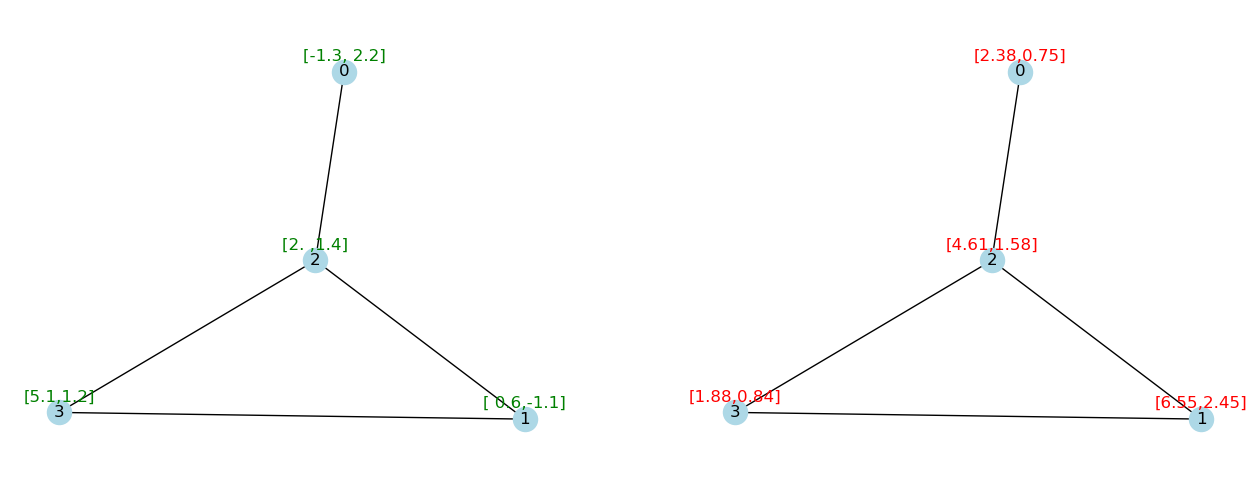

In [8]:
from typing import Callable, Dict, Tuple

def features_and_adjacency(G: nx.Graph) -> Tuple[np.ndarray, np.ndarray]:
    """Get features and adjacency matrix from graph."""
    props = nx.get_node_attributes(G, "x")
    X = np.array([props[i] for i in range(len(G))])
    A = nx.adjacency_matrix(G).toarray()
    return X, A


def feature_array_to_dict(X: np.ndarray):
    """Create feature dictionary"""

    return {node_id: {"x": x} for node_id, x in enumerate(X)}

def propagate_and_draw(
    G: nx.Graph,
    X: np.ndarray,
    A: np.ndarray,
    W: np.ndarray,
    gcn_layer_func: Callable,
    pos: Dict[int, np.ndarray] = None,
    figsize: Tuple[int, int] = (16, 6),
) -> Tuple[nx.Graph, np.ndarray]:
    """Apply propagation rule and draw before and after"""
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    if pos is None:
        pos = nx.spring_layout(G)
    draw_graph_with_attributes(G, pos=pos, ax=ax[0])
    G_1 = G.copy()
    H_1 = gcn_layer_func(X, A, W)
    nx.set_node_attributes(G_1, feature_array_to_dict(H_1))
    draw_graph_with_attributes(G_1, pos=pos, ax=ax[1], font_color="red")
    return G_1, H_1

X, A = features_and_adjacency(G)
G_1, H_1 = propagate_and_draw(G, X, A, W, gcn_layer, pos=pos)

然而，这种传播规则存在一些问题。

例如，我们**期望节点的特征会对节点本身的输出产生一些影响**。然而....

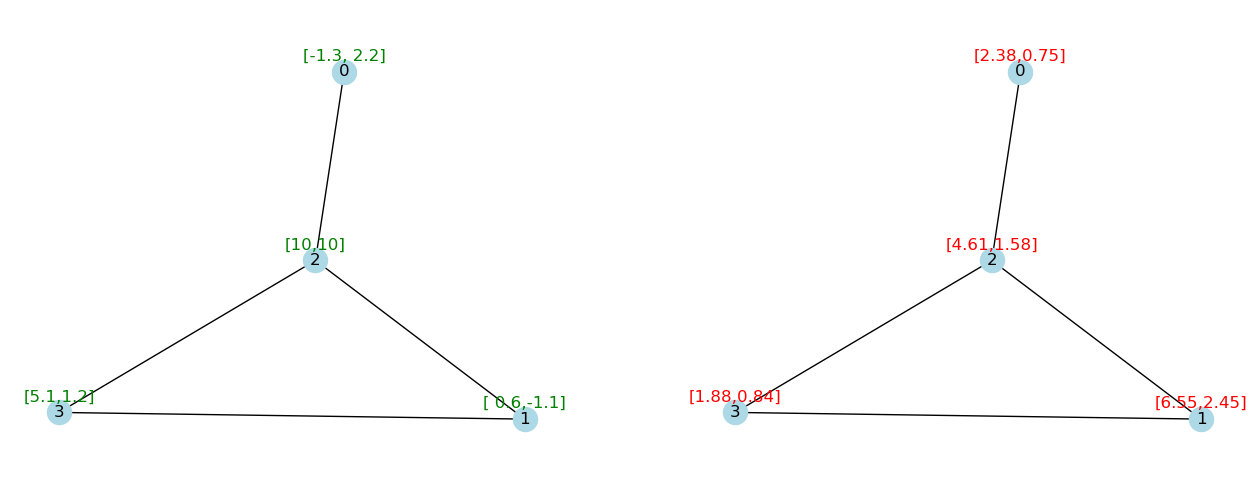

In [9]:
nx.set_node_attributes(G, {2: {"x": [10, 10]}})
G_1, H_1 = propagate_and_draw(G, X, A, W, gcn_layer, pos=pos)

我们的邻接矩阵中没有任何自循环

这意味着节点不会将其特征传播给自己。

这个问题很容易解决。

In [10]:
I = np.eye(4, 4)
I

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [11]:
A_tilde = A + I
A_tilde

array([[1., 0., 1., 0.],
       [0., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 1., 1., 1.]])

现在 $\tilde{A}$ 是包含自环的邻接矩阵！
让我们再次尝试我们的示例。

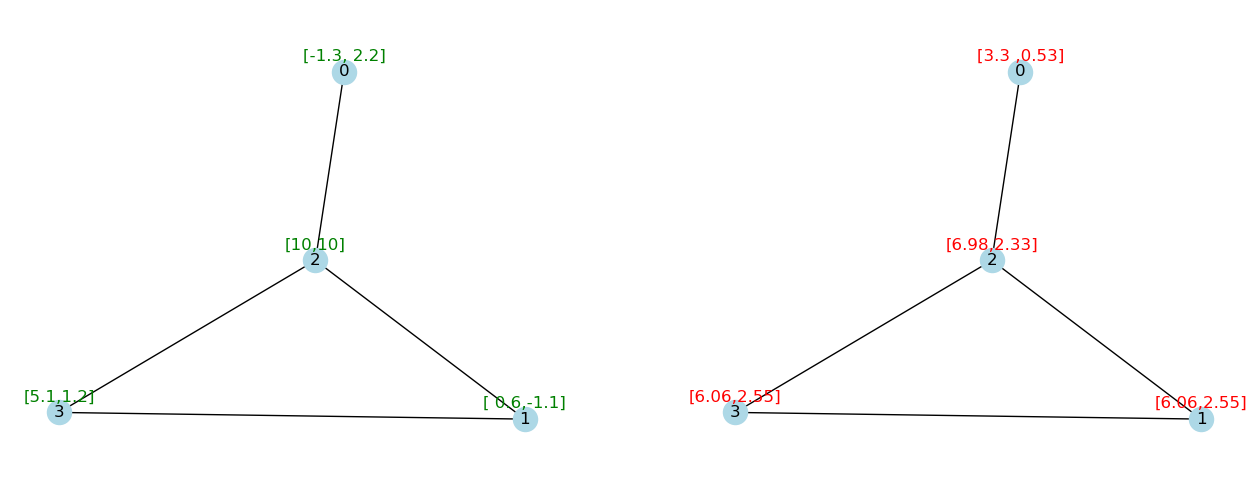

In [12]:
G_1, H_1 = propagate_and_draw(G, X, A_tilde, W, gcn_layer, pos=pos)

另一个问题是**特征矩阵A没有标准化**，这改变了乘法过程中特征的尺度。

这将使优化变得困难，并且层数越多，值就越大。

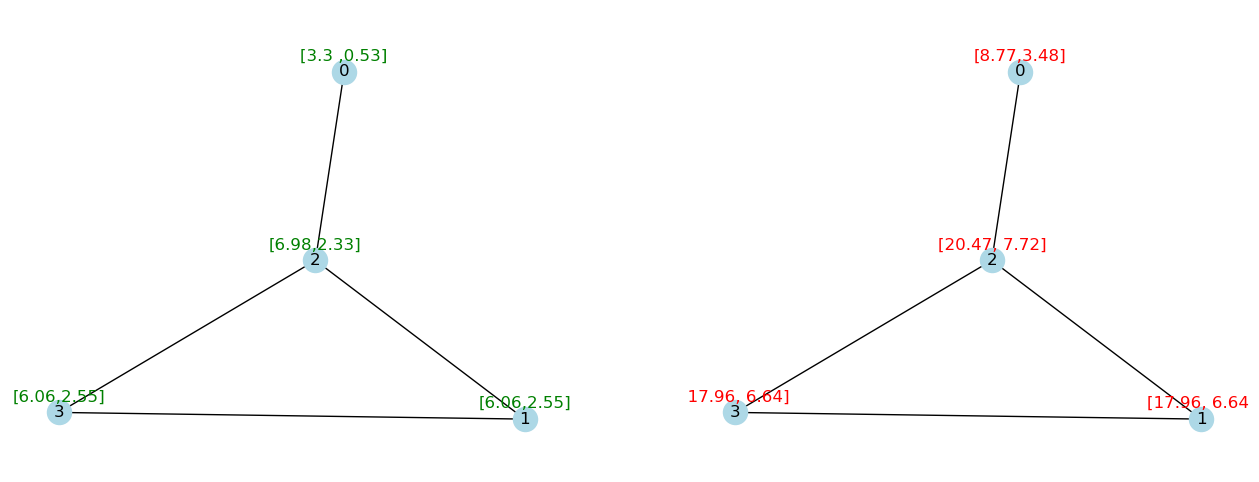

In [13]:
G_2, X_2 = propagate_and_draw(G_1, H_1, A_tilde, W, gcn_layer, pos=pos)

我们可以**通过节点度来标准化 $A$ 来解决这个问题**。


In [14]:
degree_dict = {node_id: degree for node_id, degree in nx.degree(G)}
degree_dict

{0: 1, 1: 2, 2: 3, 3: 2}

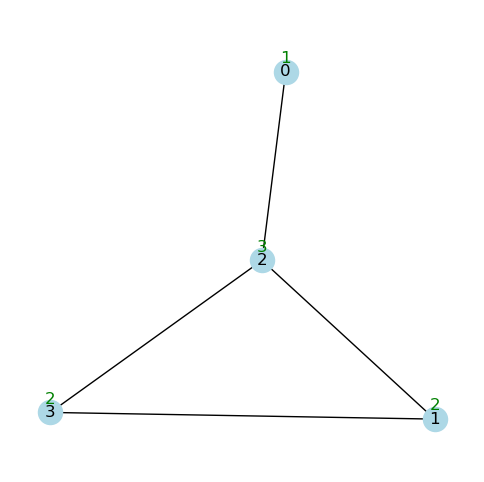

In [15]:
draw_graph_with_attributes(
    G, pos=pos, props=degree_dict, y_nudge=0.06, font_color="green"
)

In [16]:
degree_dict = nx.degree(G)
# + 1 to add self-loops into degree
D_tilde = np.array([degree_dict[i] + 1 for i in range(len(G))])
D_tilde = D_tilde * I  # create diagonal degree by point-wise multiplication
D_tilde

array([[2., 0., 0., 0.],
       [0., 3., 0., 0.],
       [0., 0., 4., 0.],
       [0., 0., 0., 3.]])

我们称上述矩阵为对角度矩阵$\tilde{D}$（它是$\tilde{A}$的对角度矩阵，即$\tilde{A}=A+I$）。

为了标准化 $A$，我们现在必须对相邻节点特征进行平均。

这可以表示为 $\tilde{D}^{-1}A$

In [17]:
from numpy.linalg import matrix_power

D_power_minus_1 = matrix_power(D_tilde, -1)
D_power_minus_1

array([[0.5       , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        ],
       [0.        , 0.        , 0.25      , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333]])

In [18]:
D_power_minus_1 @ A_tilde

array([[0.5       , 0.        , 0.5       , 0.        ],
       [0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.25      , 0.25      , 0.25      , 0.25      ],
       [0.        , 0.33333333, 0.33333333, 0.33333333]])

    归一化后，现在每行的总和为“1”

但是，现在的标准化只关注每个节点的出度（即连接到其他节点的数量），称为行标准化。

行标准化没有考虑节点的入度（即被其他节点连接的数量）。这可能导致在某些图结构中信息传播的不平衡，尤其是在有向图中。

我们可以通过再次执行列标准化来解决这个问题：

$\Large D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$

（有关标准化的更详细解释[此处](https://www.aideeplearning.cn/graph-convolutional-network%ef%bc%88gcn%ef%bc%89/)）

In [19]:
import scipy

D_power_minus_1_2 = scipy.linalg.fractional_matrix_power(D_tilde, -1 / 2)
D_power_minus_1_2

array([[0.70710678, 0.        , 0.        , 0.        ],
       [0.        , 0.57735027, 0.        , 0.        ],
       [0.        , 0.        , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.57735027]])

In [20]:
D_power_minus_1_2 @ A_tilde @ D_power_minus_1_2

array([[0.5       , 0.        , 0.35355339, 0.        ],
       [0.        , 0.33333333, 0.28867513, 0.33333333],
       [0.35355339, 0.28867513, 0.25      , 0.28867513],
       [0.        , 0.33333333, 0.28867513, 0.33333333]])

现在我们已经掌握了理解 [Kipf & Welling 在其 2017 年 ICLR 论文GCN中] (https://arxiv.org/pdf/1609.02907.pdf) 引入的传播规则所需的一切：

$f(H^{(l)},A)= \sigma(\tilde{D}^{\frac{1}{2}}\tilde{A}\tilde{D}^{\frac{1}{2}}H^{(l)}W^{(l)})$

#### <img src="https://img.icons8.com/?size=100&id=91CnU00i6HLv&format=png&color=000000" style="height:50px;display:inline"> GCN中的卷积体现在哪里？与MPNN的不同是什么？
---


## 基于谱图理论看待GCN

### 卷积的本质是局部


<center><img src="./assets/gnnconv.png" style="height:500px"></center>

### 图拉普拉斯算子

给定一个图 $G$ ，让我们固定图 $G$ 的 $n$ 个节点的任意顺序。我们用 $A$ 表示 $G$ 的 0-1 邻接矩阵，可以构建 $G$ 的对角度矩阵 $D$ :
$$
D_v=\sum_u A_{v u}
$$

其中，节点 $v$ 的度数是与 $v$ 相连的边的数量。 $A_{v u}$ 表示矩阵 $A$ 中对应于行 $v$ 和列 $u$ 的元素。我们将在本节中使用这种符号。
然后，图拉普拉斯算子 $L$ 是定义为 $L=D-A$ 的 $n \times n$ 矩阵。


<center><img src="./assets/lplssz.png" style="height:400px"></center>

### 拉普拉斯多项式

既然我们已经了解了图拉普拉斯算子是什么，我们可以构建如下形式的多项式:
$$
p_w(L)=w_0 I_n+w_1 L+w_2 L^2+\cdots+w_d L^d=\sum_{i=0}^d w_i L^i \text {. }
$$

这种形式的每个多项式可以用其系数向量 $w=\left[w_0, \ldots, w_d\right]$ 来表示。注意，对于每个 $w ， p_w(L)$是一个 $n \times n$ 矩阵，就像 $L$ 一样。

这些多项式可以被认为是卷积神经网络 (CNN) 中“卷积核”的等价物，而系数 $w$ 则是“卷积核”的权重。

为了便于说明，我们将重点关注节点具有一维特征的情况：对于 $v \in V$ 的每个 $x_v$ 只是一个实数。当每个 $x_v$ 是高维向量时，同样的思想也适用。

使用之前选定的节点顺序，我们可以将所有节点特征 $x_v$ 堆叠起来得到一个向量 $x \in \mathbb{R}^n$ 。

<center><img src="./assets/lplsjh.png" style="height:400px"></center>

一旦我们构建了特征向量 $x$ ，我们可以定义它与多项式滤波器 $p_w$ 的卷积为:
$$
x^{\prime}=p_w(L) x
$$

$$
p_w(L)=w_0 I_n+w_1 L+w_2 L^2+\cdots+w_d L^d=\sum_{i=0}^d w_i L^i \text {. }
$$

为了理解系数 $w$ 如何影响卷积，让我们先考虑“最简单的“多项式: 当 $w_0=1$ 且所有其他系数为 0 时。在这种情况下， $x^{\prime}$ 就是 $x$ :
$$
x^{\prime}=p_w(L) x=\sum_{i=0}^d w_i L^i x=w_0 I_n x=x .
$$

现在，如果我们增加多项式的阶数，并考虑 $w_1=1$ 且所有其他系数为 0 的情况。那么， $x^{\prime}$ 就是 $L x$ , 因此:
$$
\begin{aligned}
& x_v^{\prime}=(L x)_v=L_v x \\
& =\sum_{u \in G} L_{v u} x_u \\
& =\sum_{u \in G}\left(D_{v u}-A_{v u}\right) x_u \\
& =D_v x_v-\sum_{u \in \mathcal{N}(v)} x_u
\end{aligned}
$$

这里， $\mathcal{N}(v)$ 表示节点 $v$ 的邻居集合。

对于上述推导的最后一步，下面详细解释一下：

度矩阵 $D$ 是一个对角矩阵，其元素 $D_{v u}$ 只有在 $v=u$ 时非零，即 $D_{v v}=D_v$ (节点 $v$ 的度数）。因此，可以将上式进一步分解：

当 $v=u$ 时， $D_{v u}=D_v$ ；
当 $v \neq u$ 时， $D_{v u}=0$ 。
因此，上式可以写成两部分之和:
$$
(L x)_v=D_v x_v-\sum_{u \neq v} A_{v u} x_u
$$

邻接矩阵 $A$ 的元素 $A_{v u}$ 只有当节点 $v$ 和节点 $u$ 是邻居时为 1 ，否则为 0 。因此，只有当 $u$ 是 $v$的邻居时， $A_{v u}$ 才为 1 。

而，求和只需要考虑 $u$ 是 $v$ 的邻居的情况，即 $u \in \mathcal{N}(v)$ :
$$
\sum_{u \neq v} A_{v u} x_u=\sum_{u \in \mathcal{N}(v)} x_u
$$

最后，将这两部分合并在一起，我们得到:
$$
(L x)_v=D_v x_v-\sum_{u \in \mathcal{N}(v)} x_u
$$

这一步骤清楚地展示了图拉普拉斯算子如何平滑节点的特征，通过减去邻居的特征实现了特征的均衡和传播。

这个减号反映了每个节点 $v$ 的特征 $x_v$ 与其邻居节点特征 $x_u$ 的差异，起到一种平滑作用，减小相邻节点之间特征值的差异。这在图信号处理中是很有用的，因为它帮助捕捉局部结构信息并防止特征值的剧烈波动。

另一方面，在图卷积神经网络 (GCNs) 中，通常的操作是对每个节点的特征进行加权求和，这可以看作是对信息的融合。例如，在每一层卷积中，节点 $v$ 的新的特征表示 $h_v^{\prime}$ 是通过它自身的特征和邻居节点的特征加权求和得到的

结合两者的理解来说，图拉普拉斯矩阵中的减号和GCN中的加号在概念上是不同的，前者是基于图信号处理中的拉普拉斯算子定义，而后者是基于神经网络中信息融合的需求。

**还存在一个重要问题：多项式的阶数 $d$ 如何影响卷积的行为？**

对于邻接矩阵 $A$ 或拉普拉斯矩阵 $L$ ，幂次矩阵 $L^i$ 的含义与图中节点之间的连通性和路径长度有关。具体来说:
- $L^1=L: L_{v u}$ 表示节点 $v$ 和节点 $u$ 之间的直接连接关系（路径长度为1）。
- $L^2=L \cdot L:\left(L^2\right)_{v u}$ 表示节点 $v$ 和节点 $u$ 之间通过两个边连接的路径的累积效果，即2-hop 连接。
- 一般地， $\left(L^i\right)_{v u}$ 表示节点 $v$ 和节点 $u$ 之间通过 $i$ 条边连接的路径的累积效果。

虽然拉普拉斯矩阵 $L$ 的幂次不能直接被解释为路径的数量，但是它反映了节点之间的多跳 (hop) 连接关系的影响。拉普拉斯矩阵的幂次 $L^i$ 表示的是从节点 $v$ 到节点 $u$ 的 $i$ 跳内的累积影响或传播强度。

在图卷积中，我们对图拉普拉斯矩阵 $L$ 进行多项式卷积：
$$
x^{\prime}=p_w(L) x
$$

其中，
$$
p_w(L)=w_0 I_n+w_1 L+w_2 L^2+\cdots+w_d L^d=\sum_{i=0}^d w_i L^i
$$

这意味着对于每一个节点 $v$ ，其特征 $x_v^{\prime}$ 是通过其自身和最多 $d$ 跳邻居的特征的加权求和得到的。公式中的 $i$ 的取值范围是 0 到 $d$ ，这表明节点之间的传播和影响是局部化的，并且受限于多项式的阶数 $d$ 。

这个局部化的限制（即影响范围）可以通过节点的度数来理解。节点的度数越大，它的直接邻居和进一步邻居的数量就越多。这也是合理的，因为一个节点度数越大，一般意味越重要，此时考虑更多的跳数是合理的。

### 最后一个问题：上述基于拉普拉斯矩阵的多项式图卷积，与直接给出的GCN定义为啥相差这么多？

实际上，经典的GCN定义是上述基于拉普拉斯矩阵的多项式图卷积的一个特例，推导如下：

首先，我们考虑图拉普拉斯矩阵 $L$ 的定义:
$$
L=D-A
$$

其中， $D$ 是节点度矩阵， $A$ 是邻接矩阵。
对于经典GCN，我们通常使用的是对称归一化的图拉普拉斯矩阵:
$$
\tilde{L}=I-\tilde{D}^{-1 / 2} \tilde{A} \tilde{D}^{-1 / 2}
$$

其中， $\tilde{A}=A+I$ 是加上自环后的邻接矩阵， $\tilde{D}$ 是 $\tilde{A}$ 的度矩阵。我们用对称归一化的邻接矩阵来替代图拉普拉斯矩阵进行卷积:
$$
\tilde{A}_{\text {sym }}=\tilde{D}^{-1 / 2} \tilde{A} \tilde{D}^{-1 / 2}

现在，考虑多项式卷积的形式:
$$
x^{\prime}=p_w(L) x=\sum_{i=0}^d w_i L^i x
$$

对于经典 GCN，我们只考虑到 $L$ 的一次幂，即:
$$
x^{\prime}=w_0 I x+w_1 L x
$$

使用对称归一化的邻接矩阵替代 $L$ :
$$
x^{\prime}=w_0 I x+w_1 \tilde{A}_{s y m} x
$$

**进一步简化:**

对于经典 $\mathrm{GCN}$ ，假设 $w_0=1$ 和 $w_1=1$ ，我们有:
$$
x^{\prime}=I x+\tilde{A}_{s y m} x
$$

因为 $I x$ 代表的是自环（每个节点的特征保持不变），这在加自环的邻接矩阵 $\tilde{A}$ 中已经包含了自环，因此:
$$
x^{\prime}=\tilde{A}_{\text {sym }} x
$$

添加线性变换和激活函数:
现在，我们添加一个线性变换 $W$ 和激活函数 $\sigma$ ，对于图卷积网络来说，线性变换 $W$ 代表节点特征的线性映射:
$$
H^{(l+1)}=\sigma\left(\tilde{A}_{s y m} H^{(l)} W^{(l)}\right)
$$

至此，我们得到经典GCN的定义:
$$
f\left(H^{(l)}, A\right)=\sigma\left(\tilde{D}^{-1 / 2} \tilde{A} \tilde{D}^{-1 / 2} H^{(l)} W^{(l)}\right)
$$

值得注意的是，**尽管单层GCN只考虑一跳邻居，通过多层网络的叠加，可以实现逐层扩展节点的感受野，进而捕获更远的邻居信息。**

这种逐层堆叠的方式有效地利用了局部化卷积，同时也达到了扩展节点感受野的效果。

### <img src="https://img.icons8.com/bubbles/50/000000/fire-element.png" style="height:50px;display:inline"> Pytorch：conv = GCNConv()


参数:
- in_channels (int): 每个输入样本的大小。
- out_channels (int): 每个输出样本的大小。
- improved (bool, 可选): 如果设置为 True, 将使用改进的加权方案，$\hat{A}+I$ ，其中 $\hat{A}$ 是归一化后的邻接矩阵，I 是单位矩阵。(默认值: False)
- cached (bool, 可选): 如果设置为 True, 将在第一次执行时缓存计算结果，并在后续执行时重用该结果。这在固定图结构下进行训练时非常有用。(默认值: False)
- add_self_loops (bool, 可选): 如果设置为 True, 将在输入图中添加自环。(默认值: True)
- normalize (bool, 可选): 如果设置为 True, 将对邻接矩阵进行对称归一化。(默认值: True)
- bias (bool, 可选): 如果设置为 False, 层将不会学习附加偏差。(默认值: True)
- kwargs (可选): 传递给 conv.MessagePassing 的其他参数。



## <img src="https://img.icons8.com/?size=100&id=79033&format=png&color=000000" style="height:50px;display:inline"> GraphSAGE
---


GraphSAGE与GCN的区别有两个：一个是结合节点自身信息的方式不同，第二个是泛化聚合邻居点时所采用的聚合函数不同。

GraphSAGE节点信息的更新过程主要分三步：

（1）聚合邻居节点的信息，这个聚合函数有三种，将在下午展开解释；

（2）将聚合后的信息与自身的节点信息进行拼接，进行特征的融合；

（3）送入神经网络模型中进行映射，得到更新后的节点信息。

举例：图数据如下图所示，现在使用GraphSAGE对节点1进行更新。

<center><img src="./assets/graphsage1.png" style="height:300px"></center> 

节点1特征向量的更新步骤如下：

（1）聚合邻居节点: $h_{\mathrm{N}(1)}^1 \leftarrow \operatorname{AGGREGATE}\left(h_3^0, h_4^0, h_5^0, h_6^0\right)$;

（2）拼接自身信息： $h_1^1 \leftarrow \operatorname{CONCAT}\left(h_1^0, h_{\mathrm{N}(1)}^0\right)$;

（3）经过神经网络映射： $h_1^1 \leftarrow s\left(\boldsymbol{W}^1 \cdot \operatorname{CONCAT}\left(h_1^0, h_{\mathrm{N}(1)}^0\right)\right)$ 。

假设步骤 1 中聚合函数 AGGREGATE 是 Mean 函数, 则代数得:
$$
h_{\mathrm{N}(1)}^1 \leftarrow \operatorname{AGGREGATE}\left(h_3^0, h_4^0, h_5^0, h_6^0\right)=\operatorname{Mean}([0.3,0.4],[0.2,0.2],[0.7,0.8],[0.5,0.6])
$$

另外，在这个计算流程中有两个地方需要额外注意。
* 第一，GraphSAGE在聚合某节点邻居信息的时候，并不是聚合全部的邻居，而是聚合个 K 邻居，K 是一个超参数。
    * 举例，在上图中，若 K 等于3，则在聚合节点1的周围邻居时，随机从节点3、4、5、6中选择3个进行聚合。若 K 等于5，则除了选择节点1的周围4个邻居以外，再重复从这4个邻居中抽样一个节点。
    * 这样做的好处是，当图数据非常庞大时，选取某节点的全部邻居做聚合是非常耗时耗力的，若只选择其中的 K 个邻居，可以更快的进行计算。超参数 K 本质上是计算精度和计算速度之间的一种权衡。

* 第二，个需要注意的是GraphSAGE定义了三种不同的聚合函数：
    * Mean: $A G G=\sum_{u \in N(v)} \frac{h_u^{(l)}}{|N(v)|}$
    * Pool: $A G G=g\left(\left\{\operatorname{MLP}\left(h_u^{(l)}\right), \forall u \in N(v)\right\}\right)$
    * LSTM: $A G G=\operatorname{LSTM}\left(\left[h_u^{(l)}, \forall u \in p(N(v))\right]\right)$

总体而言，GraphSAGE通过邻居采样和灵活的聚合函数设计，提供了一种更高效和可扩展的图表示学习方法，尤其在处理大规模图数据时表现出显著优势（主要得益于随机采样）。而GCN更适合小规模图的场景，其基于全图的卷积操作可以在较小的图上获得良好的性能。

### <img src="https://img.icons8.com/bubbles/50/000000/fire-element.png" style="height:50px;display:inline"> Pytorch：conv = SAGEConv()


参数:
- in_channels (int 或 tuple) - 每个输入样本的大小，或使用 -1 从第一个输入推导出大小。元组对应于源和目标的维度。
- out_channels (int) - 每个输出样本的大小。
- aggr (str 或 Aggregation, 可选) - 使用的聚合方案。可以使用 `torch_geometric.nn.aggr`的任何聚合方法，例如 "mean", "max", 或 "Istm"。(默认值: "mean")
- normalize (bool, 可选) - 如果设置为 True，输出特征将进行 $\ell$ _ 归一化，即
- (默认值: False)
- root_weight (bool, 可选) - 如果设置为 False，层将不会将变换后的根节点特征添加到输出中。(默认值: True)
- project (bool, 可选) - 如果设置为 True，层将在聚合前应用线性变换和激活函数。（默认值: False)
- bias (bool, 可选) - 如果设置为 False，层将不会学习附加偏差。(默认值: True)
- kwargs (可选) - conv.MessagePassing 的其他参数。


### <img src="https://img.icons8.com/?size=100&id=56361&format=png&color=000000" style="height:50px;display:inline"> GAT
---

让我们再看看我们原来的 GCN 层传播规则：

$\Large h_{v_{i}}^{(l+1)} = \sigma \left(\sum_{j} \frac{1}{c_{ij}} h_{v_{j}}^{(l)} W^{(l)}\right)$

如前所述，$\large c_{ij}$ 是基于图结构的归一化常数。即 $\large c_{ij}=\tilde{D}^{\frac{1}{2}} \tilde{A} \tilde{D}^{\frac{1}{2}}$

在 [GAT](https://arxiv.org/pdf/1710.10903.pdf) 中，这种 *静态* 归一化的卷积运算被注意力机制取代。

我们该怎么做呢🤔

类似于Transformer中的注意力机制，GAT的计算也分为两步：计算注意力系数（attention coefficient）和加权求和（aggregate）。

* 对于顶点 $i$, 逐个计算它的邻居们 $\left(j \in N_i \quad\right)$ 和它的相似系数 $e_{i j}=\alpha\left(\left[W h_i \| W h_j\right]\right), j \in \mathcal{N}_i$ 。
* 其中, $W$ 是一个共亨参数, 通过一个单层的神经网络层来实现, 可以对节点向量进行线性映射以达到特征增维的目的。 
* $[\cdot \| \cdot]$ 是对节点 $i, j$ 的变换后的特征进行了拼接操作 (concat)。
* 最后通过 $\alpha(\cdot)$ 把拼接后的高维特征映射到一个实数上, 也是通过一个单层的神经网络层来实现。

显然，**学习节点 $i, j$ 之间的相关性, 就是通过可学习的参数 $W$ 和 $\alpha(\cdot)$ 映射完成的**, 本质上是通过神经网络模型实现的。

有了相关系数, 离注意力系数就差归一化了！其实就是使用 **softmax** 做一步映射, 公式如下:

$$
\alpha_{i j}=\frac{\exp \left(\operatorname{LeakyReLU}\left(e_{i j}\right)\right)}{\sum_{k \in N_i} \exp \left(\operatorname{LeakyReLU}\left(e_{i k}\right)\right)}
$$

至于加权求和的实现也很简单，根据计算好的注意力系数，把特征加权求和聚合（aggregate）一下。即：
$$
h_i^{\prime}=\sigma\left(\sum_{j \in N_j} \alpha_{i j} W h_j\right)
$$
$h_i^{\prime}$ 就是 GAT 输出的对于每个节点 $i$ 的新特征, 这个新特征的向量表示融合了邻域信息, $\sigma(\cdot)$ 是激活函数。最后, 与 Transformer一样, GAT 也可以用多头注意力机制来进化增强:
$$
h_i^{\prime}(K)=\|_{k=1}^K \sigma\left(\sum_{j \in N_i} \alpha_{i j}{ }^k W^k h_j\right)
$$

其中 $K$ 是注意力机制的头数, 每个头都会维护更新自己的参数, 计算得到自己的结果, $\|_{k-1}^K$​表示将所有头的计算结果进行拼接（concat）得到最后更新好的新节点向量。

多头注意力机制也可以理解成用了集成学习的方法，就像卷积中，也要靠大量的卷积核才能大显神威一样！

最后通过一个示例来复习一下GAT的计算过程，图数据如图：


<center><img src="./assets/gnn16.png" style="height:300px"></center> 

假设参数 $\boldsymbol{W}$ 和 $\boldsymbol{\alpha}$ 的值为 $\boldsymbol{W}=[1,1], \boldsymbol{\alpha}=[1,1,1,1]$ 。注意, 这些参数都是可学习的, 随着网络的训练而更新。
首先, 计算注意力系数 $e_{i j}=\boldsymbol{\alpha}\left(\boldsymbol{W} h_i, \boldsymbol{W} h_j\right)$, 以节点 1 为例, 与其它节点的相关性系数为:
$$
\begin{aligned}
& e_{12}=\alpha \cdot[0.1,0.2,0.2,0.2]=0.7 \\
& e_{13}=\alpha \cdot[0.1,0.2,0.25,0.2]=0.75 \\
& e_{14}=0 \\
& e_{15}=\alpha \cdot[0.1,0.2,0.3,0.8]=1.4 \\
& e_{16}=\alpha \cdot[0.1,0.2,0.5,0.6]=1.4
\end{aligned}
$$

$e_{14}$ 由于单向性, 即节点 1 指向 2 , 因此在计算时, 相关性为零。然后通过公式
$$
\alpha_{12}=\frac{\exp \left(\operatorname{LeakyReLU}\left(e_{12}\right)\right)}{\exp \left(\operatorname{LeakyReLU}\left(e_{12}\right)\right)+\exp \left(\operatorname{LeakyReLU}\left(e_{13}\right)\right)+\ldots+\exp \left(\operatorname{LeakyReLU}\left(e_{16}\right)\right)}
$$

然后通过加权求和对某节点的邻居做重要程度的重分配, 即:
$$
\overrightarrow{h_i^{\prime}}=\sigma\left(\sum_{j \in N_i} \alpha_{i j} W \vec{h}_j\right)
$$

以节点 1 为例:
$$
\vec{h}_1^{\prime T}=\sigma\left(\alpha_{12} \cdot W \cdot \vec{h}_2+\alpha_{13} \cdot W \cdot \vec{h}_3 \cdots\right)=\sigma\left(\alpha_{12} \cdot W \cdot[0.2,0.2]+\cdots\right)
$$


### <img src="https://img.icons8.com/bubbles/50/000000/fire-element.png" style="height:50px;display:inline"> Pytorch：conv = GATConv()


参数:
- in_channels (int): 每个输入样本的大小。
- out_channels (int): 每个输出样本的大小。
- heads (int, 可选): 使用的注意力头数量。(默认值: 1)
- concat (bool, 可选): 如果设置为 True, 多个头的输出将会连接在一起。否则，它们将进行平均。(默认值: True)
- negative_slope (float, 可选): LeakyReLU 的负斜率。(默认值: 0.2)
- dropout (float, 可选): 在注意力权重的计算过程中使用的 dropout 概率。(默认值: 0)
- add_self_loops (bool, 可选): 如果设置为 True, 将会在输入图中添加自环。(默认值: True)
- bias (bool, 可选): 如果设置为 False, 层将不会学习附加偏差。(默认值: True)
- kwargs (可选): 传递给 conv.MessagePassing 的其他参数。


### <img src="https://img.icons8.com/?size=100&id=48250&format=png&color=000000" style="height:50px;display:inline"> Demo项目：Cora
---

Planetoid（Cora、CiteSeer、PubMed）数据集是图神经网络研究中常用的基准数据集之一，用于学术论文分类任务。每个数据集包含一组论文和它们之间的引用关系，目标是根据引用网络和节点特征（如论文的词向量）对每篇论文进行分类。

Cora: 包含2708篇机器学习领域的论文，分为7个类别。


Running SAGEConv...

Epoch: 000, Loss: 1.9586, Train Acc: 0.1429, Val Acc: 0.0720, Test Acc: 0.0910
Epoch: 001, Loss: 1.9421, Train Acc: 0.1429, Val Acc: 0.0720, Test Acc: 0.0910
Epoch: 002, Loss: 1.9220, Train Acc: 0.1429, Val Acc: 0.0720, Test Acc: 0.0910
Epoch: 003, Loss: 1.8996, Train Acc: 0.2000, Val Acc: 0.0760, Test Acc: 0.0910
Epoch: 004, Loss: 1.8744, Train Acc: 0.4929, Val Acc: 0.1680, Test Acc: 0.1850
Epoch: 005, Loss: 1.8461, Train Acc: 0.6786, Val Acc: 0.3020, Test Acc: 0.2880
Epoch: 006, Loss: 1.8150, Train Acc: 0.8214, Val Acc: 0.3360, Test Acc: 0.3290
Epoch: 007, Loss: 1.7815, Train Acc: 0.8000, Val Acc: 0.3280, Test Acc: 0.3420
Epoch: 008, Loss: 1.7457, Train Acc: 0.8214, Val Acc: 0.3580, Test Acc: 0.3570
Epoch: 009, Loss: 1.7073, Train Acc: 0.8357, Val Acc: 0.3740, Test Acc: 0.3770
Epoch: 010, Loss: 1.6664, Train Acc: 0.8571, Val Acc: 0.4000, Test Acc: 0.3910
Epoch: 011, Loss: 1.6231, Train Acc: 0.8571, Val Acc: 0.4240, Test Acc: 0.4070
Epoch: 012, Loss: 1.5773, Trai

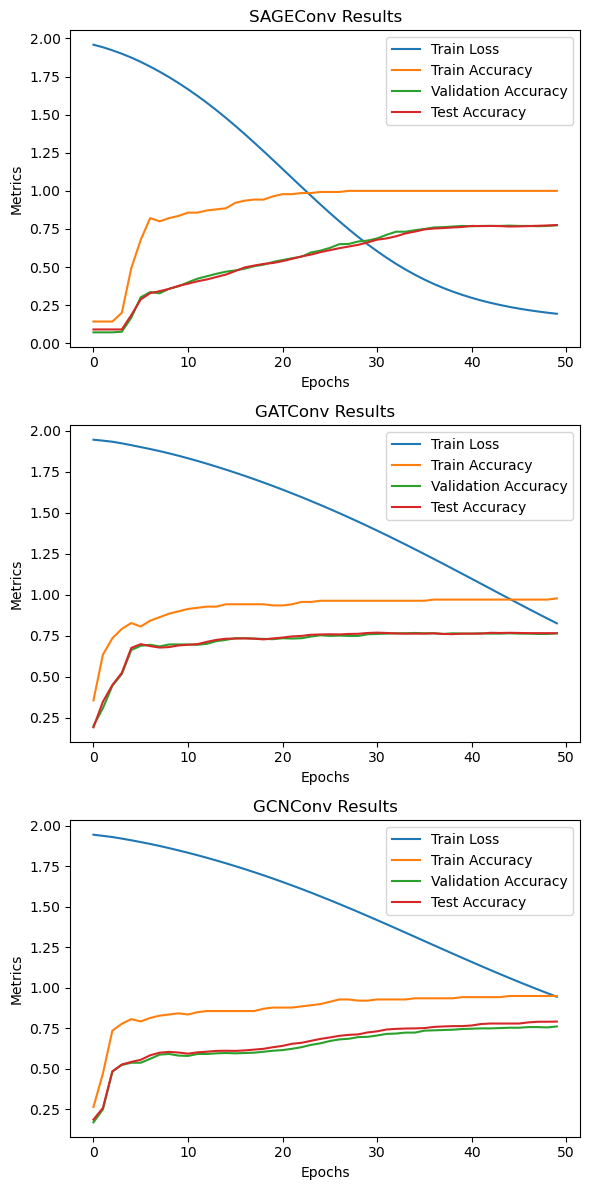

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GATConv, GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt

# 加载并归一化 Cora 数据集
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

# 定义模型架构
class GraphModel(torch.nn.Module):
    def __init__(self, conv_layer, in_channels, hidden_channels, out_channels):
        super(GraphModel, self).__init__()
        self.conv1 = conv_layer(in_channels, hidden_channels)
        self.conv2 = conv_layer(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# 训练和测试函数
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model):
    model.eval()
    logits, accs = model(data.x, data.edge_index), []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# 定义设备和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 初始化模型和优化器
def initialize_model_and_optimizer(conv_layer):
    model = GraphModel(conv_layer, dataset.num_features, 16, dataset.num_classes).to(device)
    data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    return model, optimizer

# 训练和评估模型
def train_and_evaluate(conv_layer, epochs=50):
    model, optimizer = initialize_model_and_optimizer(conv_layer)
    train_losses, train_accs, val_accs, test_accs = [], [], [], []

    for epoch in range(epochs):
        loss = train(model, optimizer)
        train_acc, val_acc, test_acc = test(model)
        train_losses.append(loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    
    return train_losses, train_accs, val_accs, test_accs

# 运行并收集结果
results = {}
for name, conv_layer in [('SAGEConv', SAGEConv), ('GATConv', GATConv), ('GCNConv', GCNConv)]:
    print(f'\nRunning {name}...\n')
    results[name] = train_and_evaluate(conv_layer)

# 可视化结果
def plot_results(results):
    fig, axes = plt.subplots(3, 1, figsize=(6, 12))

    for i, (name, (train_losses, train_accs, val_accs, test_accs)) in enumerate(results.items()):
        axes[i].plot(train_losses, label='Train Loss')
        axes[i].plot(train_accs, label='Train Accuracy')
        axes[i].plot(val_accs, label='Validation Accuracy')
        axes[i].plot(test_accs, label='Test Accuracy')
        axes[i].set_title(f'{name} Results')
        axes[i].set_xlabel('Epochs')
        axes[i].set_ylabel('Metrics')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

plot_results(results)



## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons made by <a href="https://www.flaticon.com/authors/becris" title="Becris">Becris</a> from <a href="https://www.flaticon.com/" title="Flaticon">www.flaticon.com</a>
* Icons from <a href="https://icons8.com/">Icons8.com</a> - https://icons8.com
* <a href="https://distill.pub/2021/gnn-intro/">A Gentle Introduction to Graph Neural Networks</a>
* <a href="https://paperswithcode.com/sota/node-classification-on-cora">Cora Dataset</a>